# 1. Load dataset

In [1]:
import tensorflow as tf
from pathlib import Path
import os

In [2]:
os.getcwd()

'/home/aiffel/aiffel'

In [3]:
base_dir = Path.home() / 'aiffel' / 'E4_cat_vs_dog' / 'flowers'

if not base_dir.exists():
    base_dir.mkdir(parents=True)

data_dir = base_dir / 'datasets'

In [4]:
import tensorflow_datasets as tfds

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    data_dir = data_dir,
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# 2. Pre-process

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

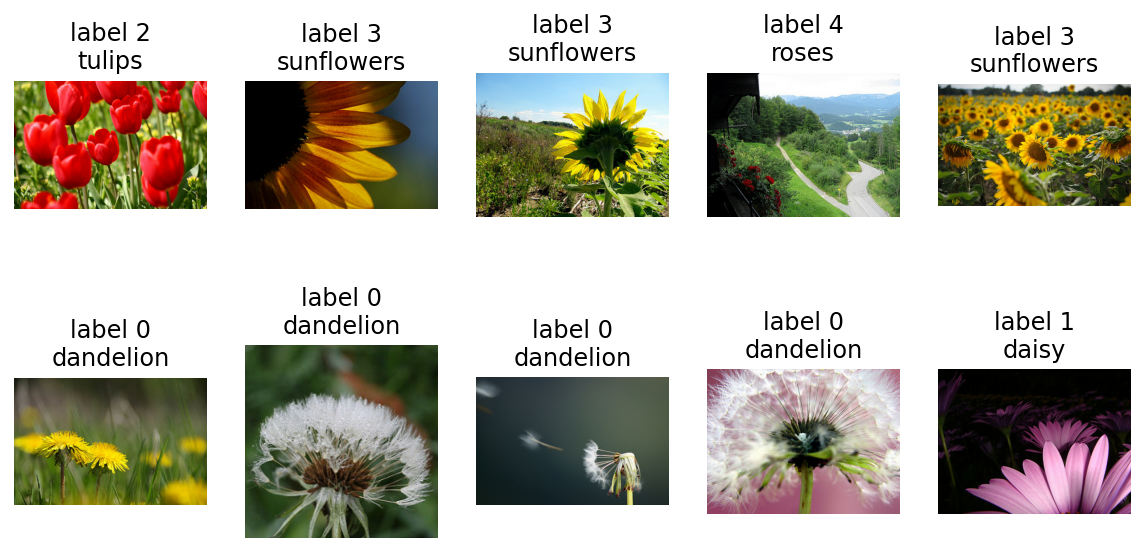

In [6]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}\n{get_label_name(label)}')
    plt.axis('off')

## Standardize sizes and values

In [7]:
def format_images(image, label, IMG_SIZE=160):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [8]:
IMG_SIZE = 160

train = raw_train.map(format_images)
validation = raw_validation.map(format_images)
test = raw_test.map(format_images)

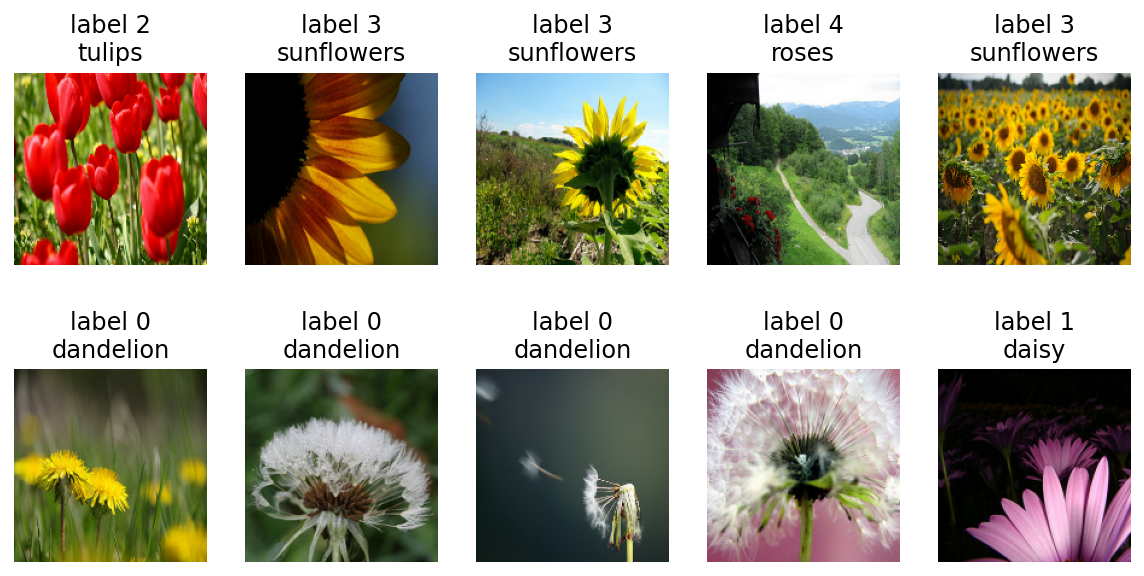

In [9]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}\n{get_label_name(label)}')
    plt.axis('off')

## set-up batch

In [29]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [30]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [31]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [32]:
train_batches.take(2)

<TakeDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>

# 3. Load pre-trained Model

In [33]:
IMG_SIZE = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [34]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

## set-up a new Model

In [35]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [36]:
base_model.trainable = False

In [37]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


# 4. Train a Model

In [39]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [40]:
validation_steps=10
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 0s 43ms/step - loss: 1.6389 - accuracy: 0.2062
initial loss: 1.64
initial accuracy: 0.21


In [55]:
EPOCHS = 15

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/15
92/92 [==============================] - 5s 60ms/step - loss: 0.4465 - accuracy: 0.8532 - val_loss: 0.5183 - val_accuracy: 0.8093
Epoch 2/15
92/92 [==============================] - 5s 59ms/step - loss: 0.4375 - accuracy: 0.8590 - val_loss: 0.4905 - val_accuracy: 0.8202
Epoch 3/15
92/92 [==============================] - 5s 59ms/step - loss: 0.4271 - accuracy: 0.8651 - val_loss: 0.4972 - val_accuracy: 0.8174
Epoch 4/15
92/92 [==============================] - 5s 59ms/step - loss: 0.4201 - accuracy: 0.8668 - val_loss: 0.4852 - val_accuracy: 0.8202
Epoch 5/15
92/92 [==============================] - 5s 59ms/step - loss: 0.4121 - accuracy: 0.8716 - val_loss: 0.4869 - val_accuracy: 0.8147
Epoch 6/15
92/92 [==============================] - 5s 59ms/step - loss: 0.4043 - accuracy: 0.8702 - val_loss: 0.4781 - val_accuracy: 0.8311
Epoch 7/15
92/92 [==============================] - 5s 59ms/step - loss: 0.3949 - accuracy: 0.8730 - val_loss: 0.4852 - val_accuracy: 0.8202
Epoch 8/15
92

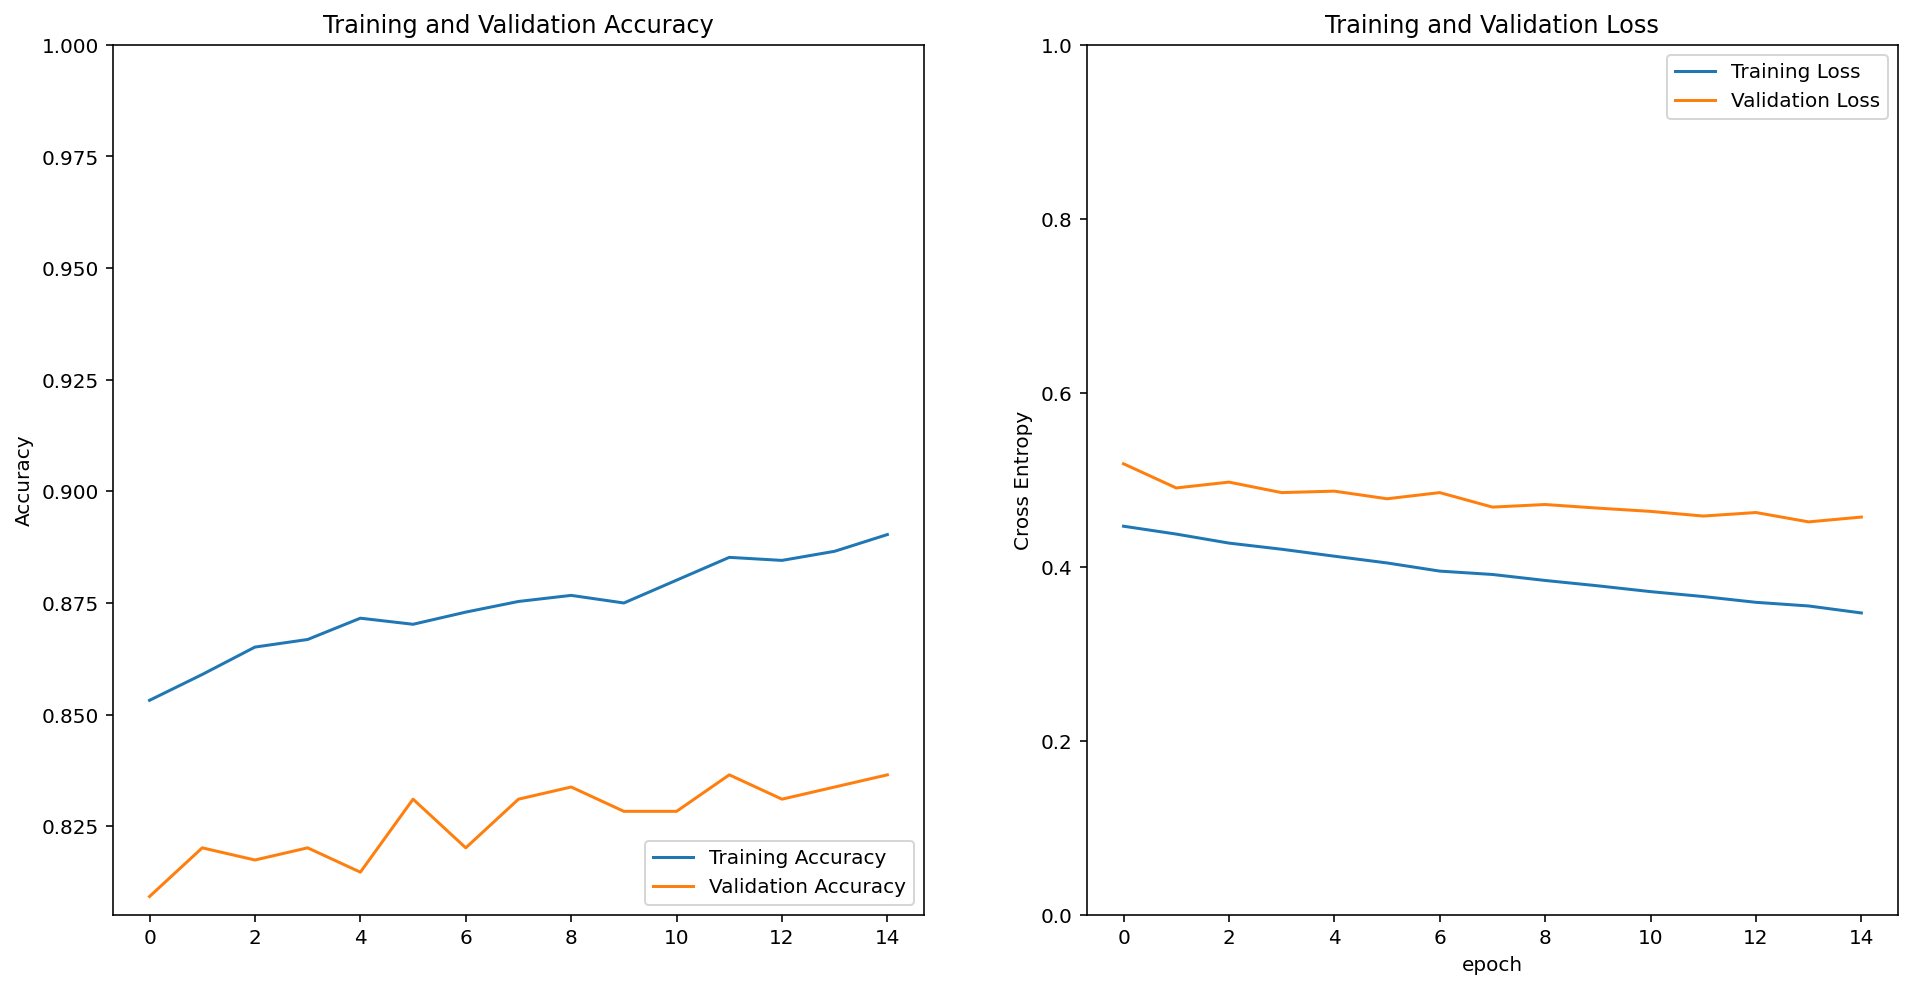

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 5. Test a Model

In [57]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[5.19149611e-03, 4.03990932e-02, 8.25842142e-01, 1.29177710e-02,
        1.15649529e-01],
       [9.99775827e-01, 2.12178988e-04, 4.22811127e-07, 4.76135892e-06,
        6.93679476e-06],
       [6.54673398e-01, 1.53975815e-01, 1.62094254e-02, 1.59089506e-01,
        1.60519481e-02],
       [4.90420673e-04, 3.28471209e-03, 6.27754390e-01, 2.30186363e-03,
        3.66168499e-01],
       [6.94007576e-01, 2.71364301e-01, 7.30638159e-03, 1.20838350e-02,
        1.52379535e-02],
       [9.52248335e-01, 3.05284541e-02, 1.38811837e-03, 1.54158045e-02,
        4.19326214e-04],
       [3.06118396e-03, 3.21775442e-03, 9.33164775e-01, 3.74073014e-02,
        2.31489930e-02],
       [3.44950110e-01, 6.16003513e-01, 2.47632212e-04, 3.78786996e-02,
        9.20028484e-04],
       [1.75934692e-03, 1.90588748e-04, 8.37104395e-03, 9.64575589e-01,
        2.51034740e-02],
       [9.99630690e-01, 3.56310979e-04, 2.65499636e-07, 1.22518468e-05,
        4.17415549e-07],
       [9.75292981e-01, 2.1662

In [58]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 3, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 2, 4, 4, 3, 0, 4])

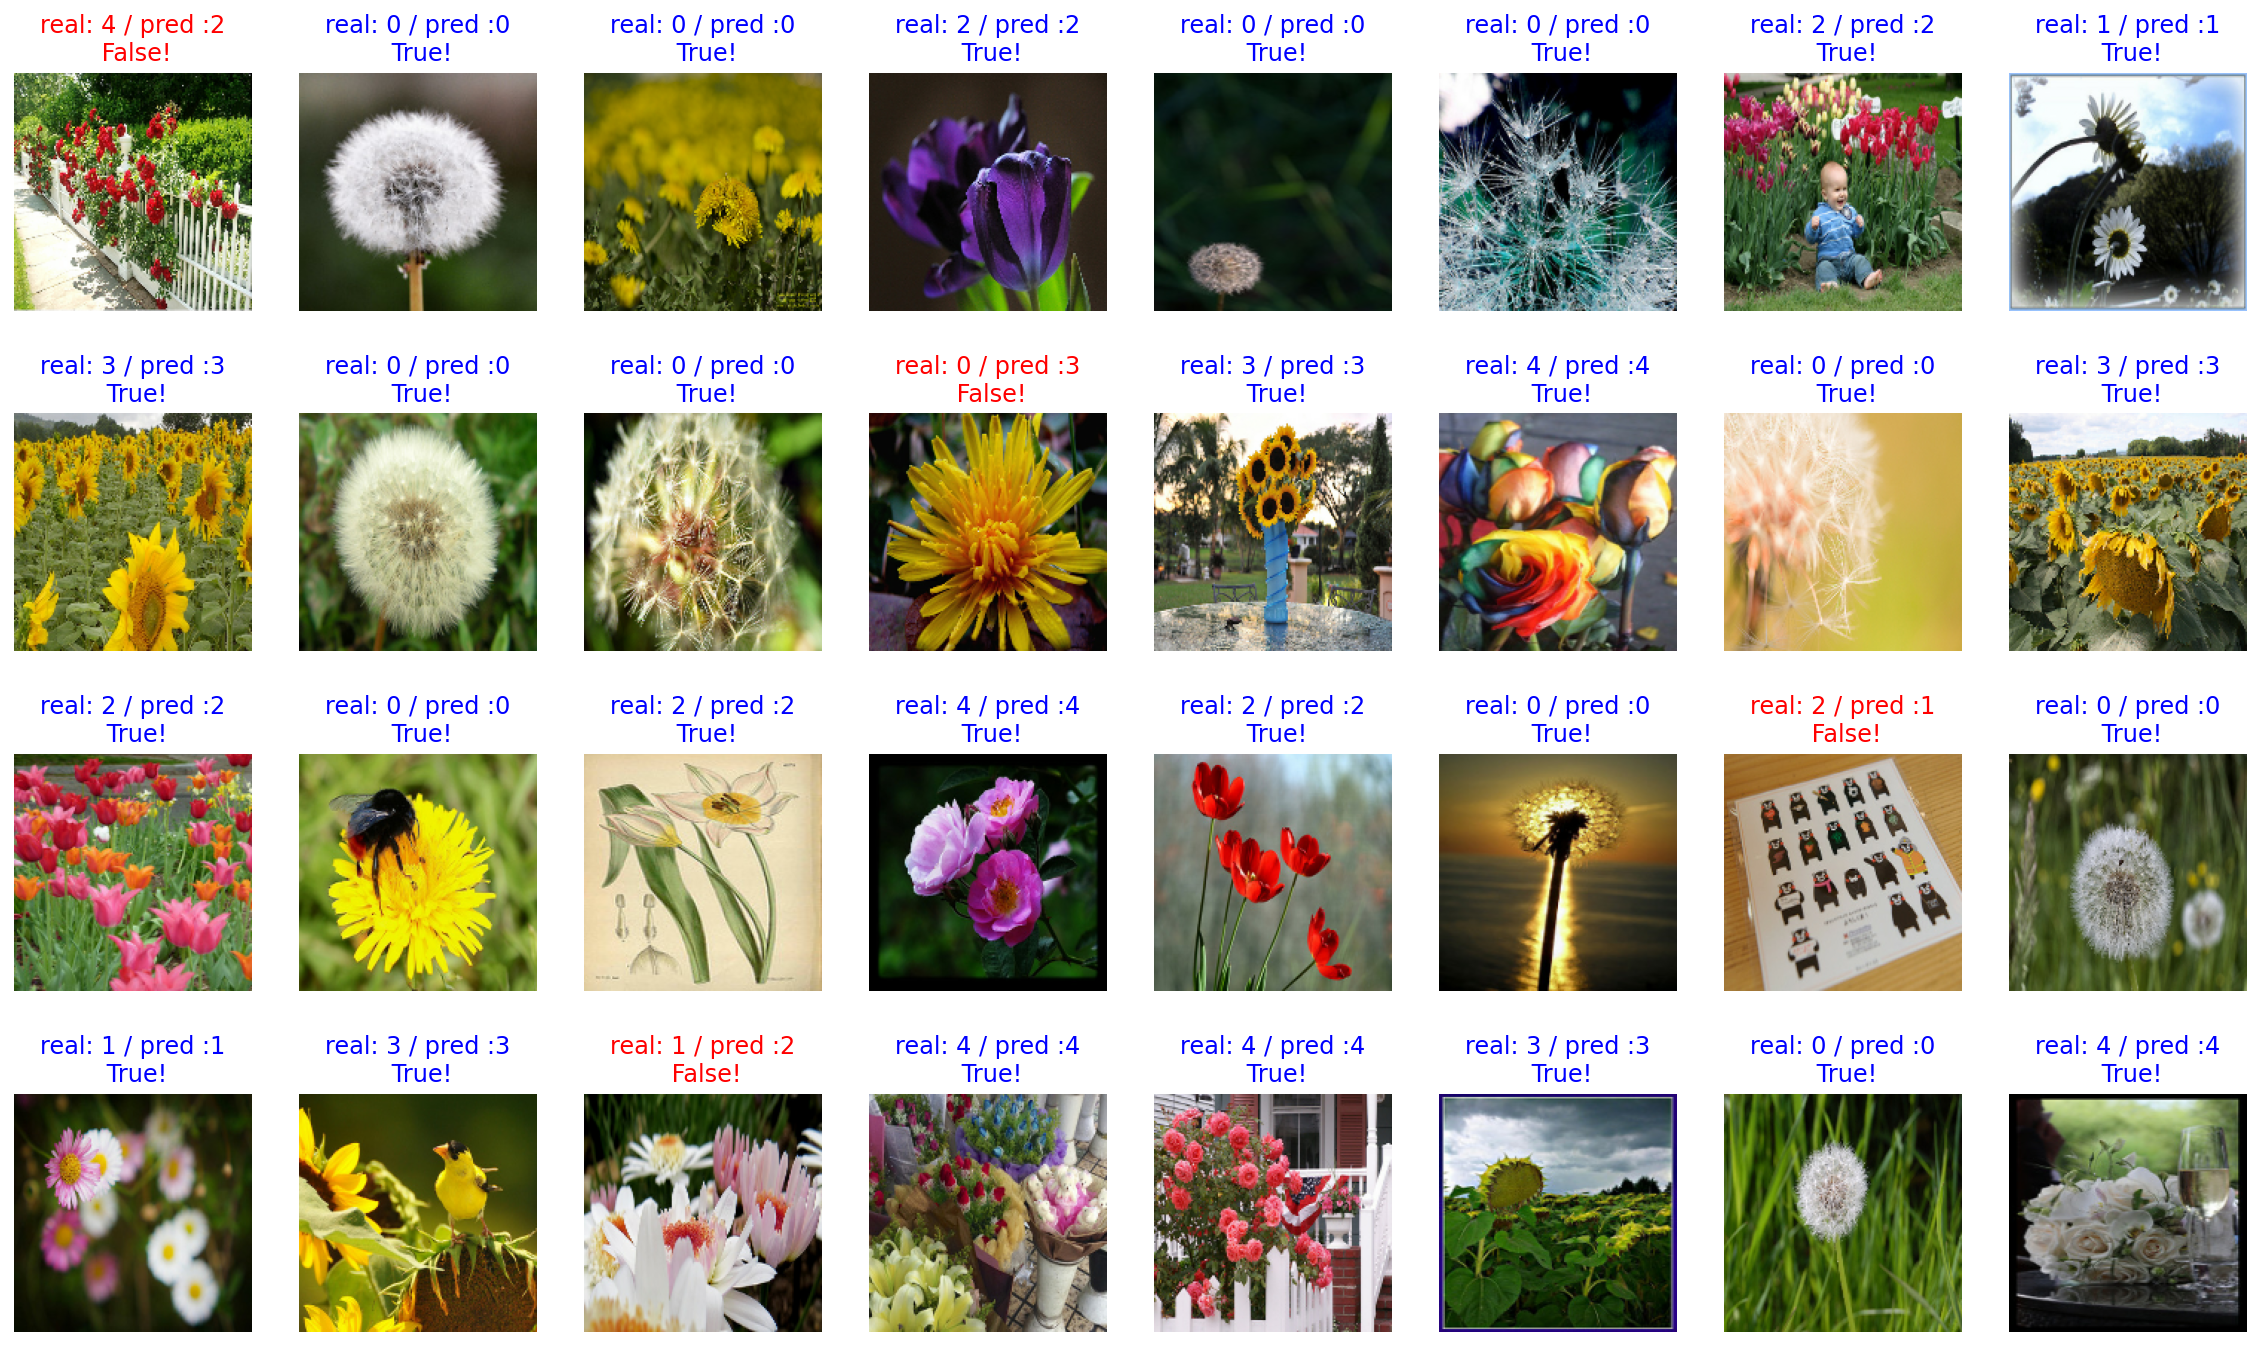

In [59]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [60]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

87.5


# 6. Save a Model

In [61]:
import os

checkpoint_dir = base_dir / 'checkpoint'

if not checkpoint_dir.exists():
    checkpoint_dir.mkdir(parents=True)
    
model.save_weights(checkpoint_dir / 'checkpoint')     # checkpoint 파일 생성

if os.path.exists(checkpoint_dir / 'checkpoint'):
  print('saving checkpoint done')

saving checkpoint done
